# Seminar 1

Fixed vs Floating point, vector norms, and stability concepts

## Fixed point

Fixed point contains a 1-bit sign, $m$-bits integer, and $n$-bits fractional part:
$$
\text{decimal} = 
(-1)^{\text{sign}} \times 
\Big(
\sum_{i=0}^{m-1} \text{integer}[i] \cdot base^{m-1-i} + 
\sum_{i=0}^{n-1} \text{fractional}[i] \cdot base^{-i-1}
\Big)
$$

- range $[-2^m + 2^{-n}, 2^m - 2^{-n}]$
- resolution $2^{-n}$
- total storage is $m + n + 1$ bits

<img src="https://i.ibb.co/k0bKtqS/fixedpoint.png" style="width:500px">

In [2]:
def binary_fixed_point_to_decimal(x, m=8, n=8):
    """
    x - binary string of size 1 + m + n
    m - size of an integer part
    n - sze of a fractional part
    """
    sign_part, integer_part, fractional_part = x[0], x[1:m+1], x[m+1:m+n+1]
    sign_value = (-1) ** int(sign_part)
    integer_value = sum([
        int(v) * 2 ** i
        for i, v in enumerate(integer_part[::-1])
    ])
    fractional_value = sum([
        int(v) * 2 ** -(i + 1)
        for i, v in enumerate(fractional_part)
    ])
    return sign_value * (integer_value + fractional_value)

m, n = 10, 5
x = '1101010100101111'
binary_fixed_point_to_decimal(x, m, n)

-681.46875

In [36]:
x = '0' + '0' * m + '0' * (n-1) + '1'
binary_fixed_point_to_decimal(x, m, n), 2**m - 2 ** (-n)

(0.00390625, 255.99609375)

In [37]:
x = '11111111111111111' # Insert a string corresponding to a minimal possible value
print(binary_fixed_point_to_decimal(x, m, n) == -(2 ** m - 2 ** (-n)))

True


In [3]:
x = '01111111111111111' # Insert a string corresponding to a maximal possible value
print(binary_fixed_point_to_decimal(x, m, n) == 2 ** m - 2 ** (-n))

True


In [4]:
x = '00000000000000001' # Insert a string corresponding to an absolute minimal but nonzero possible value
print(binary_fixed_point_to_decimal(x, m, n) == 2 ** (-n))

True


#### Floating point

Floating point contains a 1-bit sign, $m$-bits exponent, and $n$-bits mantissa part:

$$
\text{decimal} = 
(-1)^{\text{sign}} \times 
base^{\Big(\sum_{i=0}^{m-1} \text{exponent}[i] \cdot base^{m-1-i} - (2^{m-1} - 1)\Big)}
\times
\Big(1 + \sum_{i=0}^{n-1} \text{mantissa}[i] \cdot base^{-i-1}\Big)
$$

- exponent values that are all 0 and all 1 are reserved for special numbers: NaN, infinity, etc.
- total storage is $m + n + 1$ bits

<img src="https://i.ibb.co/MSk5Drs/floatingpoint.png" style="width:700px">

Half (float16) vs Single (float32) vs and Double (float32) Precision

- float16 - 16 bit total: 1 for a sign, $m = 5$ for exponent and $n = 10$ for mantissa
- float32 - 32 bits total: 1 for a sign, $m = 8$ for exponent and $n = 23$ for mantissa
- float64 - 64 bits total: 1 for a sign, $m = 11$ for exponent and $n = 52$ for mantissa

In [8]:
def binary_floating_point_to_decimal(x, m=8, n=23):
    """
    x - binary string of size 1 + m + n
    m - size of an exponent part
    n - sze of a mantissa part
    """
    if len(x) != 1 + m + n:
        raise ValueError('Length of x, should be 1 + m + n')
    sign_part, exponent_part, mantissa_part = x[0], x[1:m+1], x[m+1:n+m+1]
    sign_value = (-1) ** int(sign_part)

    mantissa_value = 1
    for i, v in enumerate(mantissa_part):
        mantissa_value += int(v) * (2 ** -(i + 1))
    print(f"{mantissa_value = }")

    exponent_value = 0
    for i, v in enumerate(exponent_part):
        exponent_value += int(v) * 2 ** i
    print(f"{exponent_value = }")
    exponent_value -= (2 ** (m - 1) - 1)
    print(f"{exponent_value = }")
        
    return sign_value * (2 ** exponent_value) * mantissa_value

m, n = 5, 8
x = '10100101101011'
# print(binary_floating_point_to_decimal(x, m, n) == 5.125)
binary_floating_point_to_decimal(x, m, n)

mantissa_value = 1.41796875
exponent_value = 18
exponent_value = 3


-11.34375

#### Rounding Errors

Due to the fact that float representations are only approximations to real numbers, some errors may occur.

For example, let's consider a simple summation algorithm, where $x_i$ are floating point numbers:

$$
f(x) = x_1 + x_2 + ... + x_n
$$

Realize a naïve algorithm from the lecture (add one-by-one) and check out the occuring error.

[!] Set $n$ as 1000 and all $x_i$ as 0.1.

In [54]:
import numpy as np
np.sum(np.array([0.1] * 1000)), sum([0.1] * 1000)

(100.00000000000001, 100.0)

In [51]:
total = 0.0
for _ in range(1000):
    total += 0.1

print("Expected result: 100.0")
print(f"Actual result:", total)

Expected result: 100.0
Actual result: 99.9999999999986


Realize a Kahan algorithm from the lecture and check out the occuring error.

[!] Set $n$ as 1000 and all $x_i$ as 0.1.

In [55]:
s = 0
c = 0
for i in range(1000):
    y = 0.1 - c
    t = s + y
    c = (t - s) - y
    s = t

print("Expected result: 100.0")
print(f"Actual result:", s)

Expected result: 100.0
Actual result: 100.0


Explanation: the value 0.1 cannot be represented precisely in binary so it becomes an approximation. When this approximation is added repeatedly, the small rounding errors accumulate, leading to a final result slightly less than 100.0.

#### Vectors and vector norms

In NLA we typically work not with numbers, but with vectors that are simply arrays of numbers of size $n$.

In [8]:
import numpy as np

x = np.array([1, 2, 3, 4, 5])

print(f'Size of the x vector is {len(x)}')
print(f'Type of the vector elements is {type(x[0])}')

Size of the x vector is 5
Type of the vector elements is <class 'numpy.int64'>


As you can see, this vector contains only integer values. Now convert them into float32 type.

In [9]:
x = x.astype(np.float32)
print(f'Type of the vector elements is {type(x[0])}')

Type of the vector elements is <class 'numpy.float32'>


In order to measure smallness of a vector its **norm** $\|x\|$ is used.
The most important class is $p$-norms:
$$
\|x\|_p = \Big(\sum_{i=1}^n |x_i|^p\Big)^{1/p}
$$
Examples of $p$-norms:
- Manhattan distance or $L_1$ norm - when $p=1$
- Euclidean norm or $L_2$ norm - when $p=2$
- Infinity norm, or Chebyshev norm - when $p=+\infty$: $ \|x\|_{\infty} = \max_i | x_i|$
  

Compute norms for the $x$ vector:

Hint: use np.linalg.norm

In [10]:
print('L1 norm:', np.linalg.norm(x, 1))
print('L2 norm:', np.linalg.norm(x, 2))
print('Chebyshev norm:', np.linalg.norm(x, np.inf))

L1 norm: 15.0
L2 norm: 7.4161983
Chebyshev norm: 5.0


A unit disk for a p-norm is a set of point such that $\|x\|_p = 1$.

Visualize p-norm unit disk for the following p-norms: $p \in (0.25, 0.75, 1.0, 2.0, 5.0, \infty)$

Hint: $y = \pm (1 - |x|^p)^{1/p}$

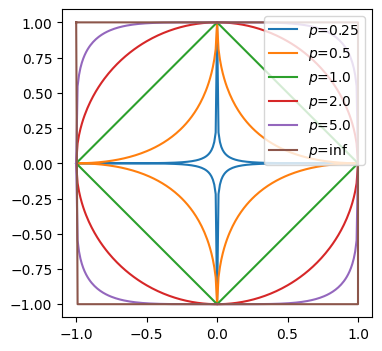

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def unit_disk(p):
    x = np.linspace(-1, 1, 201)
    y = (1 - np.abs(x) ** p) ** (1 / p)
    x = np.hstack([x, x[1:][::-1], x[0]])
    y = np.hstack([y, -y[1:][::-1], y[0]])
    return x, y

plt.figure(figsize=(4, 4))
plt.axis('equal')
for p in (0.25, 0.5, 1.0, 2.0, 5.0, np.inf):
    x, y = unit_disk(p)
    plt.plot(x, y, label=f'$p$={p}')
plt.legend(loc=1)
plt.show()

#### Stability

Suppose we have a vector $x$, function $f(x)$, and an algorithm $\text{alg}(x)$ to approximate the function. Then the algorithm is called **forward stable**, if for some small $\varepsilon$

$$
\|\text{alg}(x) - f(x)\|  \leq \varepsilon
$$

[Task] Check the summation algorithms mentioned before (naive and Kahan) to be forward stable. 

Set each $x_i$ as 0.1 againg and $n$ as 100.
$$
f(x) = \sum_{i=1}^{100} x_i, \;\;
x_i = 0.1
$$
Record the error occuring in each step of summation: 
$$
\text{error}[i] = |0.1 \cdot i - \text{alg}(x)|
$$

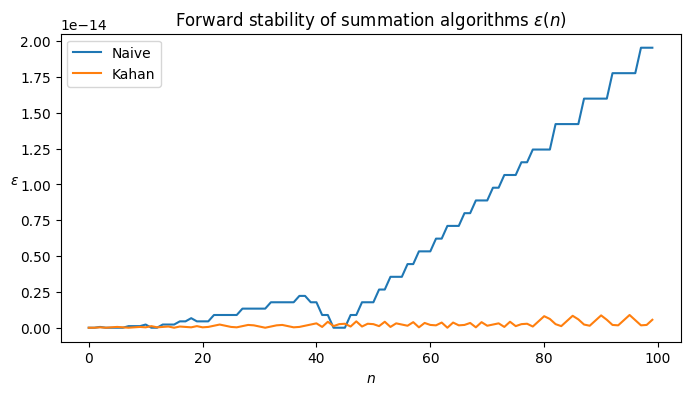

In [12]:
N = 100

# Naive
total = 0.0
error_naive = []
for i in range(N):
    total += 0.1
    refer = (i + 1) / 10
    error_naive.append(np.abs(refer - total))

# Kahan
s = 0
c = 0
error_kahan = []
for i in range(N):
    y = 0.1 - c
    t = s + y
    c = (t - s) - y
    s = t
    error_kahan.append(np.abs(c))

plt.figure(figsize=(8, 4))
plt.title(r'Forward stability of summation algorithms $\varepsilon(n)$')
plt.plot(error_naive, label='Naive')
plt.plot(error_kahan, label='Kahan')
plt.ylabel(r'$\varepsilon$', rotation=0)
plt.xlabel(r'$n$')
plt.legend()
plt.show()

What do you see?